In [49]:
#Datenerfassung
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


#Filepath
white = '/home/dl4/dst/Winequality_White.xlsx'
red = '/home/dl4/dst/Winequality_Red.xlsx'
full_colored = '/home/dl4/dst/Winequality_full.xlsx'

#Data with color
df_listC = pd.read_excel(full_colored)

df_listCnoNA = df_listC.dropna()
#Clean quality from 99 and 17 values
df_temp= df_listCnoNA[df_listCnoNA['quality']!=99]
df_listCnoNAClean =df_temp[df_temp['quality']!=17]
df_listCnoNAClean =df_listCnoNAClean[df_listCnoNAClean['pH']!=99.99] 
#df_listCnoNAClean -> Beide Weinsorten mit Farbenlabel ohne falsche pH und Quality Werte

#Auftrennung in Datensatz Rotwein und Datensatz Weißwein
df_red = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "red"]
df_white = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "white"]

df_red_org = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "red"]
df_white_org = df_listCnoNAClean.loc[df_listCnoNAClean["color"] == "white"]

#Label und ID Säule entfernen
df_red = df_red.drop(["color", "ID"], axis=1)
df_white = df_white.drop(["color", "ID"], axis=1).reset_index(drop=True)
wine_list = [df_white, df_red]
df_white

"""Sebastian"""
# Rot/Weißwein Dataset ohne "ID" und "quality"
x_red = df_red_org.iloc[:,1:15]
x_white = df_white_org.iloc[:,1:15]
# Label-Daten ("quality")
y_red = df_red_org.iloc[:,15]
y_white = df_white_org.iloc[:,15]



# "flavanoids entfernen"
x_red = x_red.drop(["flavanoids","density"], axis=1)
x_white = x_white.drop("flavanoids", axis=1)
"""Sebastian"""

#Train and test Data

#x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(df_listCnoNAClean.iloc[:,0:15], df_listCnoNAClean.iloc[:,15], test_size=0.2, random_state=1)
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(df_red_org.iloc[:,1:15], df_red_org.iloc[:,15], test_size=0.2, random_state=1)
x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(df_white_org.iloc[:,1:15], df_white_org.iloc[:,15], test_size=0.2, random_state=1)

In [50]:
"""Sebastian"""
#Skalierung
def min_max_scaler(x):
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(x)
    df_scaled = pd.DataFrame(scaled, columns = x.columns)
    
    return df_scaled


def robust_scaler(x):
    
    scaler = RobustScaler()
    scaled = scaler.fit_transform(x)
    df_scaled = pd.DataFrame(scaled, columns = x.columns)
    
    return df_scaled

#MinMax Datensatz
x_red_scaled = min_max_scaler(x_red)
x_white_scaled = min_max_scaler(x_white)

#Robust Datensatz
#x_red_robust = min_max_scaler(x_red)
#x_white_robust = min_max_scaler(x_white)
x_red_robust = robust_scaler(x_red)
x_white_robust = robust_scaler(x_white)

In [51]:
"""Sebastian"""

#Outlier removal

def outlier_removal(x_df, y_df):
    #Konvertieren zu Numpy-Array für weitere Bearbeitung
    x = x_df.to_numpy()
    y = y_df.to_numpy()
    
    ######################
    ###Isolation Forest###
    ######################
    iso_forest = IsolationForest(contamination=0.05, random_state=1)
    outlier = iso_forest.fit_predict(x)
    # Boolean Array mit Outlier = False
    mask = outlier != -1
    # Array mit Inliner
    x_iso, y_iso = x[mask, :], y[mask]
    # Dataframe erstellen
    x_iso_df = pd.DataFrame(x_iso, columns=x_df.columns)
    y_iso_df = pd.DataFrame(y_iso, columns=["quality"])
    
    ##########################
    ###Local Outlier Factor###
    ##########################
    outlier = LocalOutlierFactor().fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_lof, y_lof = x[mask, :], y[mask]
    # Dataframe erstellen
    x_lof_df = pd.DataFrame(x_lof, columns=x_df.columns)
    y_lof_df = pd.DataFrame(y_lof, columns=["quality"])
    
    ####################################
    ###Minimum Covariance Determinant###
    ####################################
    outlier = EllipticEnvelope(contamination=0.05,random_state=1).fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_mcd, y_mcd = x[mask, :], y[mask]
    # Dataframe erstellen
    x_mcd_df = pd.DataFrame(x_mcd, columns=x_df.columns)
    y_mcd_df = pd.DataFrame(y_mcd, columns=["quality"])
    
    ###################
    ###One-Class SVM###
    ###################
    outlier = OneClassSVM(nu=0.05).fit_predict(x)
    mask = outlier != -1
    #Array mit Inliner
    x_ocs, y_ocs = x[mask, :], y[mask]
    # Dataframe erstellen
    x_ocs_df = pd.DataFrame(x_ocs, columns=x_df.columns)
    y_ocs_df = pd.DataFrame(y_ocs, columns=["quality"])
    
    
    
    return (x_iso_df, y_iso_df), (x_lof_df, y_lof_df), (x_mcd_df, y_mcd_df), (x_ocs_df, y_ocs_df)

# Erstellt zu jeder Outlier Detection Methode ein Datensatz
iso, lof, mcd, ocs = outlier_removal(x_red_scaled, y_red)

x_red_iso, y_red_iso = iso
x_red_lof, y_red_lof = lof
x_red_mcd, y_red_mcd = mcd
x_red_ocs, y_red_ocs = ocs

iso, lof, mcd, ocs = outlier_removal(x_white_scaled, y_white)

x_white_iso, y_white_iso = iso
x_white_lof, y_white_lof = lof
x_white_mcd, y_white_mcd = mcd
x_white_ocs, y_white_ocs = ocs

print(len(x_white), len(x_white_iso), len(x_white_lof), len(x_white_mcd), len(x_white_ocs))
print(len(x_red), len(x_red_iso), len(x_red_lof), len(x_red_mcd), len(x_red_ocs))


"""MCD als bestes abgeschnitten, wenn es darum geht Outlier effektiv zu entfernen --> jetzt schauen ob dieser auch für das Modell am Besten ist"""

4881 4637 4843 4636 4640
1564 1485 1519 1485 1486


'MCD als bestes abgeschnitten, wenn es darum geht Outlier effektiv zu entfernen --> jetzt schauen ob dieser auch für das Modell am Besten ist'

In [52]:
"""Sebastian"""
# Skalierung des MCD Outlier Datensatzes
#Skaliert den erstellten Datensatz ohne Outlier wieder auf Range 0 bis 1
x_red_mcd_scaled = min_max_scaler(x_red_mcd)
x_white_mcd_scaled = min_max_scaler(x_white_mcd)

In [53]:
"""Sebastian"""
# Normalisieren
#Transformiert Datensatz zu einer perfekten Gauss Kurve

#PowerTransformer
def power_transformer(x):
    transformer = PowerTransformer()
    transformed = transformer.fit_transform(x)
    df_transformed = pd.DataFrame(transformed, columns = x.columns)
    return df_transformed

x_red_pt = power_transformer(x_red)
x_red_pt_scaled = min_max_scaler(x_red_pt)
x_white_pt = power_transformer(x_white)

x_red_mcd_scaled_pt = power_transformer(x_red_mcd_scaled)
x_white_mcd_scaled_pt = power_transformer(x_white_mcd_scaled)
x_white_mcd_scaled_pt

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,magnesium,alcohol,lightness
0,0.252006,0.116682,0.335639,1.938946,0.274724,0.688266,0.795737,2.129781,-1.334455,-0.119008,-0.237138,-1.639249,1.924533
1,-0.632269,0.450011,0.157092,-1.099651,0.627133,-1.441453,-0.092160,0.074283,0.776307,0.229664,0.156505,-0.827961,0.280751
2,1.474699,0.231848,0.679177,0.346924,0.712304,-0.239407,-0.988266,0.441462,0.525985,0.229664,-0.342386,-0.239099,0.280751
3,0.488397,-0.389542,-0.026241,0.644940,1.355198,0.800250,1.146687,0.602054,0.067199,0.125484,-0.793967,-0.425922,1.093013
4,0.488397,-0.389542,-0.026241,0.644940,1.355198,0.800250,1.146687,0.602054,0.067199,0.090679,-0.793967,-0.425922,-0.511005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,-0.766452,-0.673444,-0.310691,-1.099651,-0.292103,-0.660724,-1.123275,-0.983570,0.589341,-0.829327,0.248559,0.649413,-0.511005
4632,-0.241907,0.653189,0.335639,0.556826,0.453326,1.325068,0.750967,0.376151,-0.207758,1.219779,-0.134726,-0.723678,1.093013
4633,-0.370049,-0.255683,-1.350945,-1.249771,-0.097749,-0.239407,-0.619888,-0.445514,-1.415584,1.421113,-0.134726,-0.934923,1.093013
4634,-1.768471,0.342893,-0.214576,-1.288500,-2.208815,-0.960392,-0.645744,-2.038189,1.018641,-0.901400,-1.039835,1.631095,-2.026893


In [54]:
"""Sebastian"""
# Datensätze generieren // Datensatzübersicht

############################
#### Normale Datensätze ####
############################
x_red, y_red
x_white, y_white

##############################
#### Skalierte Datensätze ####
##############################
# Normal
x_red_scaled, y_red
x_white_scaled, y_white

# Ohne Outlier (MCD)
x_red_mcd_scaled, y_red_mcd
x_white_mcd_scaled, y_white_mcd

###############################
#### Gefilterte Datensätze ####
###############################
"""Alle Outlier Datensätze arbeiten mit dem Skalierten [0-1] Datensatz, MCD (Beste Outlier Reduction) wurde daraufhin nochmals auf [0-1] skaliert damit man mit diesem weiterarbeiten kann"""

# Isolation Forest
x_red_iso, y_red_iso
x_white_iso, y_white_iso

# Local Outlier Factor
x_red_lof, y_red_lof
x_white_lof, y_white_lof

# Minimum Covariance Determinant
x_red_mcd, y_red_mcd
x_white_mcd, y_white_mcd
# Minimum Covariance Determinant (Skaliert)
x_red_mcd_scaled, y_red_mcd
x_white_mcd_scaled, y_white_mcd

# One-Class SVM
x_red_ocs, y_red_ocs
x_white_ocs, y_white_ocs

##############################
#### Normierte Datensätze ####
##############################

### PowerTransformer ###
#Normaler Datensatz
x_red_pt, y_red
#Normaler Datensatz (wieder auf [0-1] skaliert, macht wahrscheinlich keinen großen Unterschied, aber kann man mal experimentieren)
x_red_pt_scaled, y_red

# Ohne Outlier (MCD)
x_red_mcd_scaled, y_red_mcd
x_white_mcd_scaled_pt, y_white_mcd


################################
#### Selektierte Datensätze ####
################################


#Zu Untersuchen. Datensatz ohne:
# Density
# Lightness
# pH bei Rotwein (wenn sklaierter Datensatz)

(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0          0.252006          0.116682     0.335639        1.938946   0.274724   
 1         -0.632269          0.450011     0.157092       -1.099651   0.627133   
 2          1.474699          0.231848     0.679177        0.346924   0.712304   
 3          0.488397         -0.389542    -0.026241        0.644940   1.355198   
 4          0.488397         -0.389542    -0.026241        0.644940   1.355198   
 ...             ...               ...          ...             ...        ...   
 4631      -0.766452         -0.673444    -0.310691       -1.099651  -0.292103   
 4632      -0.241907          0.653189     0.335639        0.556826   0.453326   
 4633      -0.370049         -0.255683    -1.350945       -1.249771  -0.097749   
 4634      -1.768471          0.342893    -0.214576       -1.288500  -2.208815   
 4635      -1.041236         -0.673444     0.509603       -1.407697  -2.471636   
 
       free su

In [55]:
#Training and Testdata
def print_trainsplit(x_train, x_test):
    print("\n","--------------Training / Testdata Stats--------------")
    total=x_train.shape[0]+x_test.shape[0]
    print("Overall number of examples in wine data set",total)
    print("Training examples: ",x_train.shape[0],", test examples: ",x_test.shape[0])
    print("Calculated percentage of training examples: ",x_train.shape[0]/total*100,"%")
    print("Calculated percentage of test examples: ",x_test.shape[0]/total*100,"%")
    
def make_trainsplit(x,y, split=0.2): #Macht Split fuer Trainings- und Testdaten. Default Split = 0.2 (Testdatenanteil)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=1)
    return x_train, x_test, y_train, y_test

In [56]:
#Regressionsanalyse
#Linear Regression
def make_regression(x_train, y_train, x_test, y_test):
    from sklearn import linear_model
    
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn import datasets
    from sklearn import svm
    from sklearn.linear_model import LogisticRegression
    ##print("--------------LinearRegression--------------")
    reg = linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    #print("Regression coefficients: ",reg.coef_)
    f_pre= reg.predict(x_test)
    #Return the coefficient of determination R^2 of the prediction.
    ##print("R^2 value of the model: ",reg.score(x_test,y_test))
    
    #Logistic Regression
    ##print("--------------LogisticRegression--------------")
    clf = LogisticRegression(random_state=1, solver="liblinear").fit(x_train, y_train)
    y_val_pred = clf.predict(x_test)
    ##print("Score Logistic Regression: ", clf.score(x_test,y_test))
    ##print("\n")
    reg = reg.score(x_test,y_test)
    log = clf.score(x_test,y_test)
    return reg, log
    
reg,log = make_regression(x_train_red, y_train_red, x_test_red, y_test_red)
print("Red Wine default Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
reg,log =make_regression(x_train_white, y_train_white, x_test_white, y_test_white)
print("White Wine default Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

x_train_red3, x_test_red3, y_train_red3, y_test_red3 = train_test_split(x_red_pt, y_red, test_size=0.2, random_state=1)
reg,log =make_regression(x_train_red3, y_train_red3, x_test_red3, y_test_red3)
print("PowerTransformer Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

x_train_red4, x_test_red4, y_train_red4, y_test_red4 = train_test_split(x_red_pt_scaled, y_red, test_size=0.2, random_state=1)
reg,log =make_regression(x_train_red4, y_train_red4, x_test_red4, y_test_red4)
print("PowerTransformer([0-1] skaliert) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

x_train_red5, x_test_red5, y_train_red5, y_test_red5 = train_test_split(x_red_mcd_scaled,y_red_mcd, test_size=0.2, random_state=1)
reg,log =make_regression(x_train_red5, y_train_red5, x_test_red5, y_test_red5)
print("Minimum Covariance Determinant (Skaliert) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

Red Wine default Scores:  0.32613045646973593 (Lin.Regr.)  0.5846645367412141 (Log.Regr.)
White Wine default Scores:  0.23918273507862386 (Lin.Regr.)  0.4790174002047083 (Log.Regr.)
PowerTransformer Scores:  0.33866104708358913 (Lin.Regr.)  0.5910543130990416 (Log.Regr.)
PowerTransformer([0-1] skaliert) Scores:  0.33866104708358913 (Lin.Regr.)  0.5718849840255591 (Log.Regr.)
Minimum Covariance Determinant (Skaliert) Scores:  0.4430299478126545 (Lin.Regr.)  0.6195286195286195 (Log.Regr.)


In [57]:
#Outlier detection/deletion
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

def make_outliers(x_train, y_train, x_test, y_test):
    reg_o, log_o = make_regression(x_train, y_train, x_test, y_test)
    print("\n")
    print("Lin. Regression Score before: ", reg_o)
    print("Log. Regression Score before: ", log_o)
    #Outliers: Isolation Forests
    print("\n")
    print("--------------Outliers: Isolation Forests--------------")
    iso = IsolationForest(contamination=0.1, random_state=1)
    y_out = iso.fit_predict(x_train)
    mask = y_out != -1
    print(x_train)
    print(mask)
    X_train_inl, y_train_inl = x_train[mask, :], y_train[mask]
    print("Inliers: ",X_train_inl.shape[0],"Outliers",x_train.shape[0]-X_train_inl.shape[0])
    reg, log = make_regression(X_train_inl, y_train_inl, x_test, y_test)
    print("Lin. Regression Score: ", reg, "Diff: ", reg-reg_o, "(",((reg-reg_o)/reg_o)*100,"% )")
    print("Log. Regression Score: ", log, "Diff: ", log-log_o, "(",((log-log_o)/log_o)*100,"% )")   
    
    #Outliers: Minimum Covariance Determinant
    print("--------------Outliers: Minimum Covariance Determinant--------------")
    y_out = EllipticEnvelope(contamination=0.1,random_state=1).fit_predict(x_train)
    mask = y_out != -1
    X_train_inl2, y_train_inl2 = x_train[mask, :], y_train[mask]
    print("Inliers: ",X_train_inl2.shape[0],"Outliers",x_train.shape[0]-X_train_inl2.shape[0])
    reg, log = make_regression(X_train_inl2, y_train_inl2, x_test, y_test)
    print("Lin. Regression Score: ", reg, "Diff: ", reg-reg_o, "(",((reg-reg_o)/reg_o)*100,"% )")
    print("Log. Regression Score: ", log, "Diff: ", log-log_o, "(",((log-log_o)/log_o)*100,"% )")    
    
    #Outliers: Local Outlier Factor
    print("--------------Outliers: Local Outlier Factor--------------")
    y_out = LocalOutlierFactor().fit_predict(x_train)
    mask = y_out != -1
    X_train_inl3, y_train_inl3 = x_train[mask, :], y_train[mask]
    print("Inliers: ",X_train_inl3.shape[0],"Outliers",x_train.shape[0]-X_train_inl3.shape[0])
    reg, log = make_regression(X_train_inl3, y_train_inl3, x_test, y_test)
    print("Lin. Regression Score: ", reg, "Diff: ", reg-reg_o, "(",((reg-reg_o)/reg_o)*100,"% )")
    print("Log. Regression Score: ", log, "Diff: ", log-log_o, "(",((log-log_o)/log_o)*100,"% )")  
    
    #Outliers: One-Class SVM
    print("--------------Outliers: One-Class SVM--------------")
    y_out = OneClassSVM(nu=0.01).fit_predict(x_train)
    mask = y_out != -1
    X_train_inl4, y_train_inl4 = x_train[mask, :], y_train[mask]
    print("Inliers: ",X_train_inl4.shape[0],"Outliers",x_train.shape[0]-X_train_inl4.shape[0])
    reg, log = make_regression(X_train_inl4, y_train_inl4, x_test, y_test)
    print("Lin. Regression Score: ", reg, "Diff: ", reg-reg_o, "(",((reg-reg_o)/reg_o)*100,"% )")
    print("Log. Regression Score: ", log, "Diff: ", log-log_o, "(",((log-log_o)/log_o)*100,"% )")  

   
print("@@@@@@@@@@@@@@@@@@@@@@---Red Wine---@@@@@@@@@@@@@@@@@@@@@@@")    
print_trainsplit(x_train_red.to_numpy(),x_test_red.to_numpy())
make_outliers(x_train_red.to_numpy(), y_train_red.to_numpy(), x_test_red.to_numpy(), y_test_red.to_numpy())
print("@@@@@@@@@@@@@@@@@@@@@@---White Wine---@@@@@@@@@@@@@@@@@@@@@@@")
print_trainsplit(x_train_white.to_numpy(),x_test_white.to_numpy())
make_outliers(x_train_white.to_numpy(), y_train_white.to_numpy(), x_test_white.to_numpy(), y_test_white.to_numpy())

@@@@@@@@@@@@@@@@@@@@@@---Red Wine---@@@@@@@@@@@@@@@@@@@@@@@

 --------------Training / Testdata Stats--------------
Overall number of examples in wine data set 1564
Training examples:  1251 , test examples:  313
Calculated percentage of training examples:  79.98721227621483 %
Calculated percentage of test examples:  20.012787723785166 %


Lin. Regression Score before:  0.32613045646973593
Log. Regression Score before:  0.5846645367412141


--------------Outliers: Isolation Forests--------------
[[ 6.4    0.8    0.    ...  0.93  11.6    0.09 ]
 [ 8.     0.43   0.36  ...  0.37   9.4    0.113]
 [ 7.9    0.52   0.26  ...  0.24   9.5    0.108]
 ...
 [ 5.     0.4    0.5   ...  0.25  13.6    0.08 ]
 [ 8.9    0.64   0.37  ...  0.34   9.3    0.11 ]
 [ 7.9    0.3    0.68  ...  0.03  12.3    0.085]]
[False  True  True ... False  True False]
Inliers:  1126 Outliers 125
Lin. Regression Score:  0.32876818611826364 Diff:  0.002637729648527709 ( 0.808795865642338 % )
Log. Regression Score:  0.59105431

In [157]:
#Wrapper approaches
#Backward elimination using Recursive feature elimination¶
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import feature_selection
import pandas as pd
import numpy as np
import time
######Timer######
start_time = time.time()
print("Execution Start: ", start_time)
#################

iris = load_iris()

x = x_train_red.to_numpy()
y = y_train_red.to_numpy()
#x = df_red.iloc[:,0:14].to_numpy()
#y = df_red.iloc[:,14].to_numpy()
print(x)
print(y)
print(x.shape)
x_y = 0
#x_y= np.concatenate((x.reshape(1251,14),y.reshape(1251,1)),1)
x_y= np.concatenate((x.reshape(1564,14),y.reshape(1564,1)),1)

#Create column list
#df_columns=x_train_red.columns.values.tolist()
df_columns=df_red.iloc[:,0:14].columns.values.tolist()
print(df_columns)
df_columns2 = np.append(df_columns, np.array('Label'))
print(df_columns2)
#Create PANDAS data frame
df = pd.DataFrame(x_y,columns=df_columns2)

print("\nOriginal Iris Data Set:")
print(df)
for i in range(2,14):
    #Create the RFE object and rank features
    num_features=i
    svc = SVC(kernel="linear", C=1)
    rfe = feature_selection.RFE(estimator=svc, n_features_to_select=num_features, step=1)
    rfe.fit(x, y)

    #extend column-mask by one column for the label (always true)
    column_mask=np.append(rfe.support_,True)
    #use list column_mask to mask df-columns list
    reduced_features = [df_columns2[i] for i in range(len(df_columns2)) if column_mask[i]]
    print("Reduced_features: ",reduced_features)
    reduced_df=df[reduced_features]

    print("\nIris Data Set reduced to ",num_features," features: \n",reduced_df)


    x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(reduced_df.iloc[:,0:i], reduced_df.iloc[:,i], test_size=0.2, random_state=1)

    reg, log = make_regression(x_train_red, y_train_red, x_test_red, y_test_red)
    print("Lin. Regression Score: ", reg)
    print("Log. Regression Score: ", log)

reduced_df_NA = reduced_df[reduced_df.isna().any(axis=1)]
print(reduced_df_NA)

######Timer######
end_time = time.time()
print("Execution End: ", end_time)
print("Execution time: ", end_time-start_time)
#################

Execution Start:  1607960402.1505842
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9       0.08   
1               7.8              0.88         0.00             2.6       0.10   
2               7.8              0.76         0.04             2.3       0.09   
3              11.2              0.28         0.56             1.9       0.08   
4               7.4              0.70         0.00             1.9       0.08   
...             ...               ...          ...             ...        ...   
1592            6.8              0.62         0.08             1.9       0.07   
1594            5.9              0.55         0.10             2.2       0.06   
1595            6.3              0.51         0.13             2.3       0.08   
1596            5.9              0.65         0.12             2.0       0.08   
1597            6.0              0.31         0.47             3.6      

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
print(reduced_df.iloc[:,0:2])
print(reduced_df.iloc[:,2])

Red Wine default Scores:  0.3261973111225165 (Lin.Regr.)  0.5910543130990416 (Log.Regr.)
White Wine default Scores:  0.2391827350786282 (Lin.Regr.)  0.4759467758444217 (Log.Regr.)
Red scaled normal Scores:  0.32619731112251593 (Lin.Regr.)  0.5623003194888179 (Log.Regr.)
White scaled normal Scores:  0.23918273507863086 (Lin.Regr.)  0.49027635619242577 (Log.Regr.)
Red filtered Isolation Forest Scores:  0.3655076764744919 (Lin.Regr.)  0.6060606060606061 (Log.Regr.)
White filtered Isolation Forest Scores:  0.21035419459657112 (Lin.Regr.)  0.5086206896551724 (Log.Regr.)
Red filtered Local Outlier Factor Scores:  0.2709566786782315 (Lin.Regr.)  0.5526315789473685 (Log.Regr.)
White filtered Local Outlier Factor Scores:  0.2607734617332562 (Lin.Regr.)  0.5263157894736842 (Log.Regr.)
Red One-Class SVM Scores:  0.3193219084628137 (Lin.Regr.)  0.6006711409395973 (Log.Regr.)
white One-Class SVM Scores:  0.27916367935930964 (Lin.Regr.)  0.5247844827586207 (Log.Regr.)
Red PowerTransformer (default. 

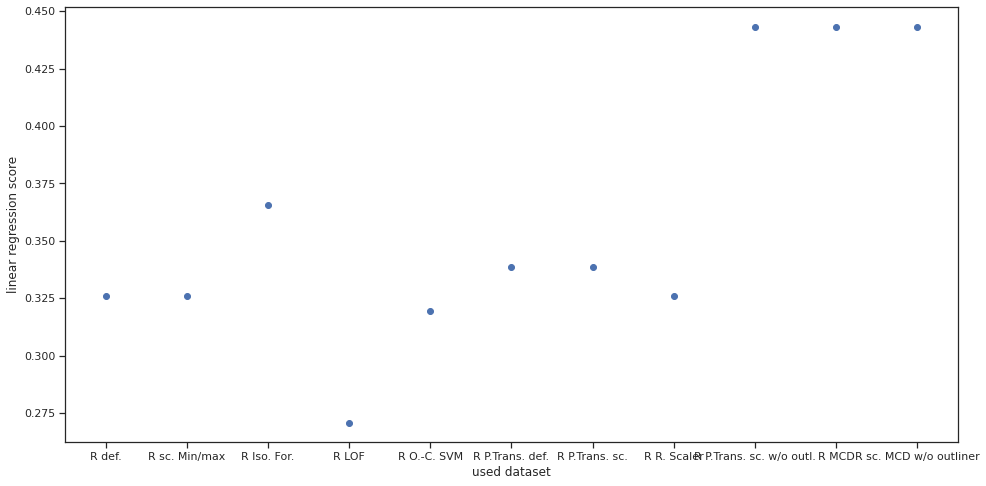

Highest Reg. Score:  0.4430299478126545 with 10 features


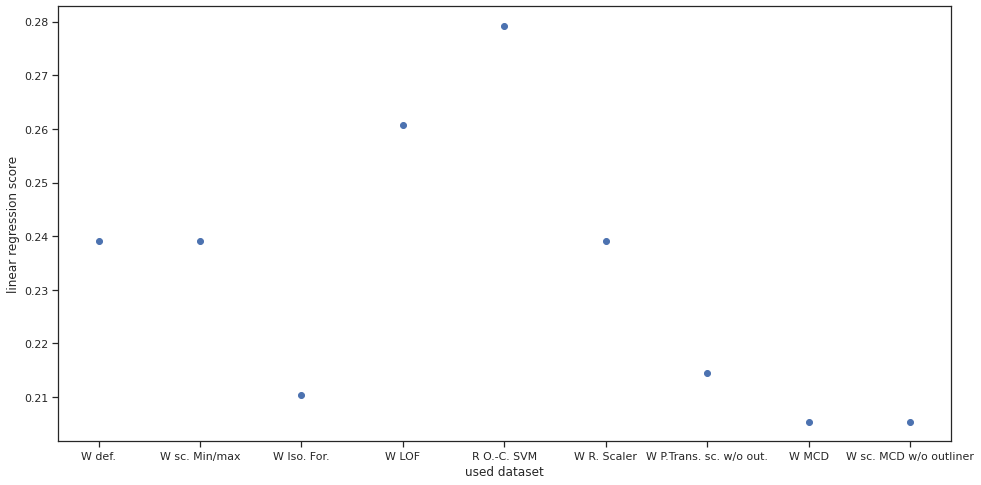

Highest Reg. Score:  0.27916367935930964 with 6 features


In [65]:
#test aller Anpassungen
import matplotlib.pyplot as plt
my_list_kindR = []
my_list_kindW = []
my_list_regR = []
my_list_regW = []

x_train, x_test, y_train, y_test=make_trainsplit(x_red, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red Wine default Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R def.")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white, y_white)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White Wine default Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W def.")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_scaled, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red scaled normal Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R sc. Min/max")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_scaled, y_white)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White scaled normal Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W sc. Min/max")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_iso, y_red_iso)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red filtered Isolation Forest Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R Iso. For.")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_iso, y_white_iso)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White filtered Isolation Forest Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W Iso. For.")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_lof, y_red_lof)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red filtered Local Outlier Factor Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R LOF")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_lof, y_white_lof)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White filtered Local Outlier Factor Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W LOF")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_ocs, y_red_ocs)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red One-Class SVM Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R O.-C. SVM")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_ocs, y_white_ocs)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("white One-Class SVM Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("R O.-C. SVM")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_pt, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red PowerTransformer (default. Datensatz) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R P.Trans. def.")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_pt_scaled, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red PowerTransformer (skalierter Datensatz) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R P.Trans. sc.")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_robust, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("red Robust Scaler Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R R. Scaler")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_robust, y_white)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("white Robust Scaler Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W R. Scaler")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_mcd_scaled, y_red_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red PowerTransformer (Ohne Outlier) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R P.Trans. sc. w/o outl.")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_mcd_scaled_pt, y_white_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("white PowerTransformer (Ohne Outlier) Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W P.Trans. sc. w/o out.")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_mcd, y_red_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red Minimum Covariance Determinant Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R MCD")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_mcd, y_white_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White Minimum Covariance Determinant Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W MCD")
my_list_regW.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_red_mcd_scaled, y_red_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Red without outlier scaled Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindR.append("R sc. MCD w/o outliner")
my_list_regR.append(reg)

x_train, x_test, y_train, y_test=make_trainsplit(x_white_mcd_scaled, y_white_mcd)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("White without outlier scaled Scores: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
my_list_kindW.append("W sc. MCD w/o outliner")
my_list_regW.append(reg)

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(my_list_kindR, my_list_regR)   
ax.set_ylabel('linear regression score')
ax.set_xlabel('used dataset')
#plt.plot(my_list_kindR, my_list_regR)
plt.show()  

import operator
index, value = max(enumerate(my_list_regR), key=operator.itemgetter(1))
print("Highest Reg. Score: ",value, "with",index+2,"features")

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(my_list_kindW, my_list_regW)   
ax.set_ylabel('linear regression score')
ax.set_xlabel('used dataset')
#plt.plot(my_list_kindW, my_list_regW)
plt.show()  

index, value = max(enumerate(my_list_regW), key=operator.itemgetter(1))
print("Highest Reg. Score: ",value, "with",index+2,"features")


In [161]:
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
import seaborn as sns
#Create Seaborn scatter matrix
sns.set(style="ticks", color_codes=True)

##Erste Darstellung 
#df_red_org_new=df_red_org.drop("flavanoids", axis=1)
#g = sns.pairplot(df_red_org_new,hue="quality")

my_list_lin = []
my_list_1vR = []
my_list_multi= []
my_list_ord=[]

for i in range(2,13):
    #Perform PCA with 2 dimensions
    num_components=i
    pca = decomposition.PCA(n_components=num_components)
    #Only use features
    #x=x_red_mcd_scaled
    #y=y_red_mcd
    x=x_red_iso
    y=y_red_iso
    pca.fit(x)
    x_tran = pca.transform(x)
    print(i)
    #Reconstruct data frame
    
    x_y=0
    x_y= np.concatenate((x_tran.reshape(1485,num_components),y.values.reshape(1485,1)),1)
    tran = pd.DataFrame(x_y)
    acc_linear, acc_1vR, acc_multi,acc_ordinal = make_all_regression(tran.iloc[:,0:i],tran.iloc[:,i])

#Plot iris data in seaborn scatter matrix
#sns.set(style="ticks")
#sns.pairplot(tran, hue="quality")
ax.plot(my_list_i, my_list_lin)
ax.plot(my_list_i, my_list_1vR)
ax.plot(my_list_i, my_list_multi)
ax.plot(my_list_i, my_list_ord)
ax.set_ylabel('regression score')
ax.set_xlabel('number of features')
ax.legend(my_list_type[0:3])
#plt.plot(my_list_i, my_list_reg)
plt.show()   

import operator
index, value = max(enumerate(my_list_lin), key=operator.itemgetter(1))
print("Highest Lin. Reg. Score: ",value)

index, value = max(enumerate(my_list_1vR), key=operator.itemgetter(1))
print("Highest Log. Reg. (one vs. rest) Score: ",value)

index, value = max(enumerate(my_list_multi), key=operator.itemgetter(1))
print("Highest Log. Reg. (multinomial) Score: ",value)

index, value = max(enumerate(my_list_ord), key=operator.itemgetter(1))
print("Highest Ordered Log. Reg. Score: ",value)

2
Accuracy:
Linear regression:  0.5158249158249157
Logistic regression (one vs. rest):  0.3245791245791246
Logistic regression (multinomial):  0.14612794612794616
Ordered logistic regression:  nan
3
Accuracy:
Linear regression:  0.569023569023569
Logistic regression (one vs. rest):  0.36767676767676766
Logistic regression (multinomial):  0.26329966329966326
Ordered logistic regression:  nan
4
Accuracy:
Linear regression:  0.5663299663299662
Logistic regression (one vs. rest):  0.36363636363636365
Logistic regression (multinomial):  0.3070707070707071
Ordered logistic regression:  nan
5
Accuracy:
Linear regression:  0.5777777777777777
Logistic regression (one vs. rest):  0.3865319865319865
Logistic regression (multinomial):  0.33131313131313134
Ordered logistic regression:  nan
6
Accuracy:
Linear regression:  0.597979797979798
Logistic regression (one vs. rest):  0.4094276094276094
Logistic regression (multinomial):  0.3488215488215488
Ordered logistic regression:  nan
7
Accuracy:
Linea

[0.0341668  0.10793181 0.06130488 0.0391394  0.03457086 0.01598485
 0.07861729 0.02353518 0.09934111 0.03542167 0.16142354 0.09439585]
(1564, 12)
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.247788          0.397260         0.00        0.068493   0.116667   
1          0.283186          0.520548         0.00        0.116438   0.150000   
2          0.283186          0.438356         0.04        0.095890   0.133333   
3          0.584071          0.109589         0.56        0.068493   0.116667   
4          0.247788          0.397260         0.00        0.068493   0.116667   
...             ...               ...          ...             ...        ...   
1480       0.194690          0.342466         0.08        0.068493   0.100000   
1481       0.115044          0.294521         0.10        0.089041   0.083333   
1482       0.150442          0.267123         0.13        0.095890   0.116667   
1483       0.115044          0.363014       

KeyboardInterrupt: 

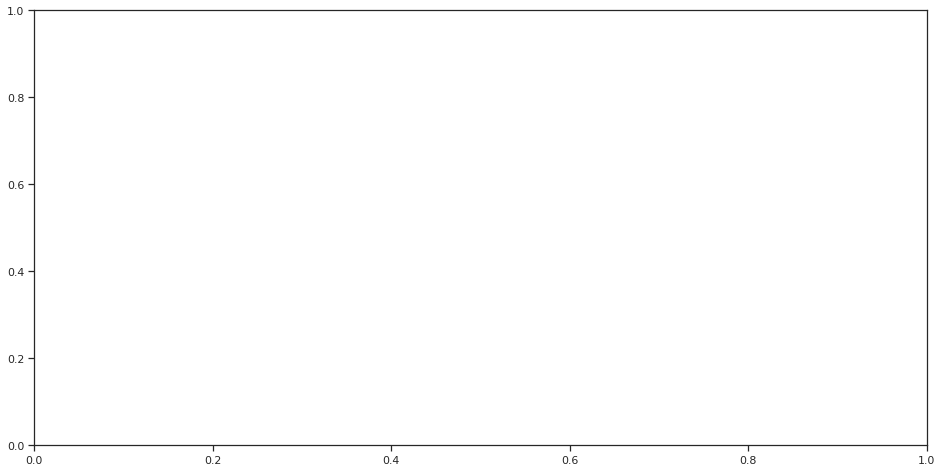

In [162]:
#Information gain classifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

mi = mutual_info_regression(x_red, y_red)
print(mi)

#Automatically adjust columns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
x=x_red
y=y_red
#x=x_white_ocs
#y=y_white_ocs
#Construct data frame
print(x_red.shape)
column_names_old=x.columns.values.tolist()
column_names = np.append(column_names_old, np.array('quality'))
#column_names=['a'+str(i) for i in range(1, x.shape[1]+1)]
#column_names.append('quality')
df=pd.DataFrame(np.column_stack([x,y]),columns=column_names)
##print('Original data frame:',df.head)
my_list_i = []
my_list_reg = []

my_list_lin = []
my_list_1vR = []
my_list_multi= []
#my_list_ord=[]

fig, ax = plt.subplots(figsize=(16,8))
print(x_red_iso)
for i in range(2,13):
    #Select 10 features using Mutual Information = Information Gain
    print("Nr. of features: ",i)
    sel = SelectKBest(mutual_info_classif, k=i)
    sel.fit(x, y)
    remaining_columns= df.columns[sel.get_support(indices=True)] 
    remaining_columns= remaining_columns.insert(len(remaining_columns),'quality')
    reduced_df=df[remaining_columns]
    print(reduced_df.columns.values.tolist())
    ##print('Reduced data frame (first rows): \n',reduced_df)
    #x_train, x_test, y_train, y_test=make_trainsplit(reduced_df.iloc[:,0:i], reduced_df.iloc[:,i])
    #reg, log=make_regression(x_train, y_train,x_test, y_test)
    #print("Mutal Information classifier with features=",i,": ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")
    my_list_i.append(i)
    #my_list_reg.append(reg)
    acc_linear, acc_1vR, acc_multi,acc_ordinal = make_all_regression(reduced_df.iloc[:,0:i],reduced_df.iloc[:,i])
    #my_list_lin.append(np.mean(acc_linear))
    #my_list_1vR.append(np.mean(acc_1vR))
    #my_list_multi.append(np.mean(acc_multi))
    #my_list_ord.append(np.mean(acc_ordinal))
    
print(my_list_lin)
ax.plot(my_list_i, my_list_lin)
#ax.plot(my_list_i, my_list_1vR)
#ax.plot(my_list_i, my_list_multi)
#ax.plot(my_list_i, my_list_ord)

ax.set_ylabel('regression score')
ax.set_xlabel('number of features')
ax.legend(my_list_type[0:3])
#plt.plot(my_list_i, my_list_reg)
plt.show()   

import operator
index, value = max(enumerate(my_list_lin), key=operator.itemgetter(1))
print("Highest Lin. Reg. Score: ",value)

index, value = max(enumerate(my_list_1vR), key=operator.itemgetter(1))
print("Highest Log. Reg. (one vs. rest) Score: ",value)

index, value = max(enumerate(my_list_multi), key=operator.itemgetter(1))
print("Highest Log. Reg. (multinomial) Score: ",value)

index, value = max(enumerate(my_list_ord), key=operator.itemgetter(1))
print("Highest Ordered Log. Reg. Score: ",value)

#fig, ax = plt.subplots(figsize=(16,8))
#ax.scatter(my_list_i, my_list_reg)   
#ax.set_ylabel('linear regression score')
#ax.set_xlabel('number of features')
#plt.plot(my_list_i, my_list_reg)
#plt.show()   

#x_train, x_test, y_train, y_test=make_trainsplit(x[['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol', 'lightness']], y)
#reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Mutal Information classifier with features=",5,": ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

#Mit normiertem total sulfur dioxide


In [158]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_red_new1 = x_red.copy()
x_red_new1[['total sulfur dioxide','free sulfur dioxide']] = mms.fit_transform(x_red_new1[['total sulfur dioxide','free sulfur dioxide']])
print(x_red_new1.isnull().sum())
print(x_red_new1.describe())

x_train, x_test, y_train, y_test=make_trainsplit(x_red_new1, y_red)
reg, log=make_regression(x_train, y_train,x_test, y_test)
print("Lin. Regression Score: ",reg,"(Lin.Regr.) ", log, "(Log.Regr.)")

make_all_regression(x_red_new1, y_red)


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
pH                      0
sulphates               0
magnesium               0
alcohol                 0
lightness               0
dtype: int64
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1564.000000       1564.000000  1564.000000     1564.000000   
mean        8.323210          0.528261     0.270729        2.537052   
std         1.748636          0.179835     0.195365        1.411277   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.300000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dio

(array([0.58146965, 0.56230032, 0.59105431, 0.58146965, 0.62820513]),
 array([0.47284345, 0.41214058, 0.45047923, 0.38658147, 0.48076923]),
 array([0.42811502, 0.34824281, 0.35782748, 0.32268371, 0.42628205]),
 array([0.58146965, 0.57188498, 0.60702875, 0.57507987, 0.63461538]))

default
Accuracy:
Linear regression:  0.5888998115835176
Logistic regression (one vs. rest):  0.40665806504464647
Logistic regression (multinomial):  0.37276972229048905
Ordered logistic regression:  0.5908085524698944
scaled
Accuracy:
Linear regression:  0.5888998115835176
Logistic regression (one vs. rest):  0.429055050380929
Logistic regression (multinomial):  0.3644773490620136
Ordered logistic regression:  0.5940157286802654
scaled w/o outlier
Accuracy:
Linear regression:  0.5939393939393939
Logistic regression (one vs. rest):  0.43905723905723903
Logistic regression (multinomial):  0.36969696969696975
Ordered logistic regression:  0.5878787878787879
Iso. forests
Accuracy:
Linear regression:  0.6
Logistic regression (one vs. rest):  0.42558922558922563
Logistic regression (multinomial):  0.3575757575757576
Ordered logistic regression:  0.6026936026936026
local outlier foctor
Accuracy:
Linear regression:  0.5984453708528747
Logistic regression (one vs. rest):  0.42925134618725025
L

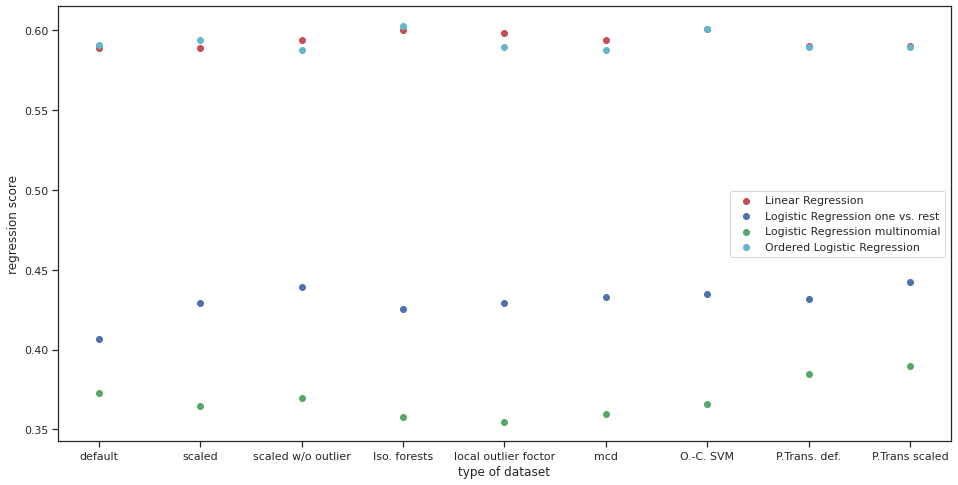

Highest Lin. Reg. Score:  0.6009445687298036 with  O.-C. SVM
Highest Log. Reg. (one vs. rest) Score:  0.442467436716638 with  P.Trans scaled
Highest Log. Reg. (multinomial) Score:  0.3893872368313263 with  P.Trans scaled
Highest Ordered Log. Reg. Score:  0.6026936026936026 with  Iso. forests


In [73]:
# choose models
#from warnings import filterwarnings
#filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from mord import LogisticAT

model_linear = LinearRegression()
model_1vR = LogisticRegression(multi_class='ovr',
    class_weight='balanced')
model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',max_iter=2000) #max_iter manuell auf 200 gesetzt, davor wurde default Wert genutzt
model_ordinal = LogisticAT(alpha=0)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt


reds_x = [x_red, x_red_scaled,x_red_mcd_scaled,x_red_iso,x_red_lof, x_red_mcd,x_red_ocs,x_red_pt,x_red_pt_scaled]
reds_y = [y_red,y_red,y_red_mcd,y_red_iso,y_red_lof,y_red_mcd,y_red_ocs,y_red,y_red]

whites_x =[x_white,x_white_scaled,x_white_mcd_scaled,x_white_lof,x_white_mcd,x_white_mcd_scaled,x_white_ocs,x_white_mcd_scaled_pt]
whites_y =[y_white,y_white,y_white_mcd,y_white_lof,y_white_mcd,y_white_mcd,y_white_ocs,y_white_mcd]

desc = ['default','scaled','scaled w/o outlier','Iso. forests','local outlier foctor', 'mcd', 'O.-C. SVM',
        'P.Trans. def.','P.Trans scaled', 'P.trans. scaled w/o outlier']
desc_w = ['default','scaled','scaled w/o outlier','Iso. forests','local outlier foctor', 'mcd', 'O.-C. SVM','P.trans. scaled w/o outlier']
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

my_list_lin = []
my_list_1vR = []
my_list_multi= []
my_list_ord=[]
my_list_desc=[]
my_list_type=['Linear Regression', 'Logistic Regression one vs. rest','Logistic Regression multinomial','Ordered Logistic Regression']
def make_all_regression(x,y):
    i=0
    features = x  #alle ausser quality
    target = y.values.ravel()

    MAE = make_scorer(mean_absolute_error)
    folds = 5

    MAE_linear = cross_val_score(model_linear,
        features,
        target,
        cv=folds,
        scoring=MAE)
    MAE_1vR = cross_val_score(model_1vR,
        features,
        target,
        cv=folds,
        scoring=MAE)
    MAE_multi = cross_val_score(model_multi,
        features,
        target,
        cv=folds,
        scoring=MAE)
    MAE_ordinal = cross_val_score(model_ordinal,
        features,
        target,
        cv=folds,
        scoring=MAE)

    from sklearn.metrics import accuracy_score

    def acc_fun(target_true, target_fit):
        target_fit = np.round(target_fit)
        target_fit.astype('int')
        return accuracy_score(target_true, target_fit)

    acc = make_scorer(acc_fun)
    folds = 5
    print('Accuracy:' )
    acc_linear = cross_val_score(model_linear,
        features,
        target,
        cv=folds,
        scoring=acc)
    print('Linear regression: ', np.mean(acc_linear))
    acc_1vR = cross_val_score(model_1vR,
        features,
        target,
        cv=folds,
        scoring=acc)
    print('Logistic regression (one vs. rest): ', np.mean(acc_1vR))
    acc_multi = cross_val_score(model_multi,
        features,
        target,
        cv=folds,
        scoring=acc)
    print('Logistic regression (multinomial): ', np.mean(acc_multi))
    acc_ordinal = cross_val_score(model_ordinal,
        features,
        target,
        cv=folds,
        scoring=acc)
    print('Ordered logistic regression: ', np.mean(acc_ordinal))
    
    my_list_lin.append(np.mean(acc_linear))
    my_list_1vR.append(np.mean(acc_1vR))
    my_list_multi.append(np.mean(acc_multi))
    my_list_ord.append(np.mean(acc_ordinal))
    
    return acc_linear, acc_1vR, acc_multi,acc_ordinal

for i in range(0,9): #range(0,9) bei rot; range(0,8) bei white
    print(desc[i])
    my_list_desc.append(desc[i])
    make_all_regression(reds_x[i], reds_y[i])

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(my_list_desc, my_list_lin,color='r')
ax.scatter(my_list_desc, my_list_1vR,color='b')
ax.scatter(my_list_desc, my_list_multi,color='g')
ax.scatter(my_list_desc, my_list_ord,color='c')
ax.set_ylabel('regression score')
ax.set_xlabel('type of dataset')
ax.legend(my_list_type)
#plt.plot(my_list_i, my_list_reg)
plt.show()   

import operator
index, value = max(enumerate(my_list_lin), key=operator.itemgetter(1))
print("Highest Lin. Reg. Score: ",value, "with ",my_list_desc[index])

index, value = max(enumerate(my_list_1vR), key=operator.itemgetter(1))
print("Highest Log. Reg. (one vs. rest) Score: ",value, "with ",my_list_desc[index])

index, value = max(enumerate(my_list_multi), key=operator.itemgetter(1))
print("Highest Log. Reg. (multinomial) Score: ",value, "with ",my_list_desc[index])

index, value = max(enumerate(my_list_ord), key=operator.itemgetter(1))
print("Highest Ordered Log. Reg. Score: ",value, "with ",my_list_desc[index])

In [47]:
x_red_real_new1=x_red_scaled[['citric acid','residual sugar','chlorides','free sulfur dioxide',
                              'total sulfur dioxide','pH','sulphates','magnesium','alcohol']]

x_red_real_new2=x_red_scaled[['residual sugar','pH','magnesium']]

make_all_regression(x_red_scaled, y_red)

Accuracy:
Linear regression:  0.5888998115835176
Logistic regression (one vs. rest):  0.429055050380929
Logistic regression (multinomial):  0.3644773490620136
Ordered logistic regression:  0.5940157286802654


(array([0.58146965, 0.56230032, 0.59105431, 0.58146965, 0.62820513]),
 array([0.42811502, 0.39936102, 0.46645367, 0.38019169, 0.47115385]),
 array([0.39936102, 0.33226837, 0.35463259, 0.32907348, 0.40705128]),
 array([0.58146965, 0.57188498, 0.60702875, 0.57507987, 0.63461538]))

In [107]:
x_red_end_new = x_red_iso[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol', 'lightness']]
#print(x_red_end_new)
make_all_regression(x_red_end_new, y_red_iso)
x_red_end_new2 = x_red_iso[['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'sulphates', 'magnesium', 'alcohol', 'lightness']]
#print(x_red_end_new2)
make_all_regression(x_red_end_new2, y_red_iso)
x_red_end_new3 = x_red_iso[['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol', 'lightness']]
#print(x_red_end_new3)
make_all_regression(x_red_end_new3, y_red_iso)
x_red_end_new4 = x_red_iso[['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'magnesium', 'alcohol', 'lightness']]
#print(x_red_end_new4)
make_all_regression(x_red_end_new4, y_red_iso)


Accuracy:
Linear regression:  0.6060606060606061
Logistic regression (one vs. rest):  0.44713804713804717
Logistic regression (multinomial):  0.3569023569023569
Ordered logistic regression:  0.6026936026936027
Accuracy:
Linear regression:  0.6094276094276094
Logistic regression (one vs. rest):  0.4316498316498317
Logistic regression (multinomial):  0.36026936026936024
Ordered logistic regression:  0.6020202020202021
Accuracy:
Linear regression:  0.6074074074074074
Logistic regression (one vs. rest):  0.44377104377104376
Logistic regression (multinomial):  0.3602693602693603
Ordered logistic regression:  0.6013468013468013
Accuracy:
Linear regression:  0.6080808080808081
Logistic regression (one vs. rest):  0.43367003367003365
Logistic regression (multinomial):  0.3595959595959596
Ordered logistic regression:  0.6
Accuracy:
Linear regression:  0.6080808080808081
Logistic regression (one vs. rest):  0.43367003367003365
Logistic regression (multinomial):  0.3595959595959596
Ordered logist

(array([0.58922559, 0.61952862, 0.58922559, 0.5993266 , 0.64309764]),
 array([0.44781145, 0.41077441, 0.45454545, 0.4006734 , 0.45454545]),
 array([0.40740741, 0.32659933, 0.32659933, 0.35690236, 0.38047138]),
 array([0.6026936 , 0.58249158, 0.60606061, 0.58585859, 0.62289562]))

In [152]:
x_white_end_new = x_white.drop(["density", "lightness"], axis=1)
#print(x_red_end_new4)
print(x_white_end_new.columns.values.tolist())
make_all_regression(x_white_end_new, y_white)
#print(x_white_end_new.describe())

x_white_end_new2 = x_white.drop(["density", "lightness", 'citric acid','fixed acidity','total sulfur dioxide'], axis=1)
#print(x_red_end_new4)
make_all_regression(x_white_end_new2, y_white)
#print(x_white_end_new.describe())

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

x_white_end_new[['total sulfur dioxide','free sulfur dioxide']] = mms.fit_transform(x_white_end_new[['total sulfur dioxide','free sulfur dioxide']])
#print(x_white_end_new.describe())
make_all_regression(x_white_end_new, y_white)


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'magnesium', 'alcohol']
Accuracy:
Linear regression:  0.49970405389533024
Logistic regression (one vs. rest):  0.2524023860261423
Logistic regression (multinomial):  0.20691792372099266
Ordered logistic regression:  0.4986794637313959
Accuracy:
Linear regression:  0.4919152809705187
Logistic regression (one vs. rest):  0.26326199305334164
Logistic regression (multinomial):  0.22003267781935332
Ordered logistic regression:  0.4935563031696226
Accuracy:
Linear regression:  0.49970405389533024
Logistic regression (one vs. rest):  0.2692014698726446
Logistic regression (multinomial):  0.22023423997852237
Ordered logistic regression:  0.49888417202208163


(array([0.44421699, 0.48258197, 0.49590164, 0.5307377 , 0.54508197]),
 array([0.29682702, 0.2295082 , 0.31352459, 0.28381148, 0.22233607]),
 array([0.2569089 , 0.17418033, 0.23463115, 0.26741803, 0.16803279]),
 array([0.44524053, 0.4795082 , 0.49897541, 0.52766393, 0.54303279]))

In [153]:
x_red_end_new5 = x_white[['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'magnesium', 'alcohol', 'lightness']]
#print(x_red_end_new5)
make_all_regression(x_red_end_new5, y_white)

x_red_end_new5[['total sulfur dioxide','free sulfur dioxide']] = mms.fit_transform(x_red_end_new5[['total sulfur dioxide','free sulfur dioxide']])
#print(x_white_end_new.describe())
#make_all_regression(x_red_end_new5, y_white)


Accuracy:
Linear regression:  0.49151089819957383
Logistic regression (one vs. rest):  0.26182463043441784
Logistic regression (multinomial):  0.21244861318522745
Ordered logistic regression:  0.498476433377519
